# Maximum A Posteriori Estimation
110062802 呂宸漢

## Part 1: Split data into training and testing data
首先我使用`pandas`讀取csv的資料，由於這次助教提供的csv檔是用逗號分隔並且沒有每個欄位的title，因此在使用`pd.read_csv`讀取檔案時須增加「`header=None`」。在讀取完資料後我先使用`np.unique`整理csv檔中的label類別，再將資料依照類別分類，雖然本次作業的資料是有依照類別排序好的，不過以此種方式時做在遇到沒有排序好的資料時也可以正常運作。由於本次作業的spec要求每個類別都要隨機取出18筆資料作為testing data，因此分類完成後便可以將同類別的資料shuffle並取出前18筆資料作為testing data，其餘的資料作為training data，最後將training data和testing data轉成`pandas`的`DataFrame`並依照spec的要求存成`train.csv`與`test.csv`便完成第一階段的資料分割。

In [1]:
import pandas as pd
import numpy as np

def split_data(input_path: str, n_trains: list) -> tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(input_path, header=None)
    labels = np.unique(df.values.T[0]).astype(int)

    label_to_data = {}
    for label in labels:
        label_to_data[label] = []
    for data in df.values:
        label_to_data[int(data[0])].append(data)

    train_list = []
    test_list = []
    for label, n_train in zip(labels, n_trains):
        data_array = np.array(label_to_data[label])
        np.random.shuffle(data_array)
        train_list.append(data_array[:n_train])
        test_list.append(data_array[n_train:])

    train_array =  np.concatenate(train_list)
    test_array = np.concatenate(test_list)
    return train_array, test_array

np.random.seed(0)
train_array, test_array = split_data('Wine.csv', n_trains=[41, 53, 30])

train_df = pd.DataFrame(train_array)
train_df[0] = train_df[0].apply(int)
train_df.to_csv('train.csv', header=None, index=False)

test_df = pd.DataFrame(test_array)
test_df[0] = test_df[0].apply(int)
test_df.to_csv('test.csv', header=None, index=False)

In [2]:
X_train, y_train = train_array[:, 1:], train_array[:, 0].astype(int)
X_test, y_test = test_array[:, 1:], test_array[:, 0].astype(int)

## Part 2: Build MAP model and predict
在MAP estimation的部分我建了一個`class`叫`MAP_Estimation`。
在`MAP_Estimation`中我放了三個成員變數：
* `labels`: 為一個list，用來記錄有哪幾種label。
* `priors`: 為一個dict，用來記錄label對應的prior。
* `parameters`: 為一個dict，用來記錄各個label中各個feature的$\mu$與$\sigma$。

在`MAP_Estimation`中我模仿`scikit-learn`的模式實作了兩個function，分別是`fit(X, y)`與`predict(X)`。
* `fit(X, y)`: 此function主要是透過training data更新estimation所需的參數，主要分為三個部分：
    1. 紀錄label array `y`中有哪些label並存進`self.labels`。
    2. 計算各個label在training data中的佔比(機率)並存進`self.priors`。
    3. 計算各個label的各個feature `x`的$\mu$與$\sigma$，由於training data在先前會先照label分類完成，因此只需針對同label的同feature用`np.mean`與`np.std`計算即可得到$\mu$與$\sigma$，最後在存進`self.parameters`。
* `predict(X)`: 此function主要是預測`x`的類別並回傳，MAP的預測方法利用`x`計算對應到的每個label的posterior，再取posterior最大的label當作預測的label，實作流程如下：
    1. 從`self.labels`中選擇一個label。
    2. 依據MAP的公式$\underset{c \in C}{\operatorname{argmax}} P(c|x) = \frac{P(x|c)P(c)}{P(x)}$，其中$P(c|x)$是posterior、$P(x|c)$是likelihood、$P(c)$是prior，所以posterior正比於likelihood乘上prior。又因為spec所述各個feature的likelihood為常態分佈且各自獨立，因此可以使用$\frac{1}{\sigma \sqrt{2\pi}}e^{-\frac{(x-\mu)^2}{2\sigma ^2}}$計算likelihood，將所有feature的likelihood相乘再乘上prior即可得到該label的posterior。由於在`fit(X, y)`的時候就有計算各label的prior與各個label的各個feature的$\mu$與$\sigma$，引此只需要利用查表的方式將相應的數字填入公式即可計算。
    3. 每個label的posterior計算完後再取posterior最大的label即為預測的結果。

建完`MAP_Estimation`便可以將先前分出來的training data與testing data餵進去測試並計算accuracy，一般而言都會在90%以上。

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score

class MAP_Estimation:
    def __init__(self) -> None:
        self.labels = []
        self.priors = {}
        self.parameters = {}
    
    def _likelihood(self, x: float, mean: float, sigma: float) -> float:
        return np.exp(-((x - mean) ** 2 / (2 * sigma ** 2))) / (sigma * np.sqrt(2 * np.pi))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.__init__()
        self.labels, n_labels = np.unique(y, return_counts=True)

        label_to_data = {}
        for i, label in enumerate(self.labels):
            label_to_data[label] = []
            self.priors[label] = n_labels[i] / np.sum(n_labels)
        for i, label in enumerate(y):
            label_to_data[label].append(X[i])

        for label in self.labels:
            data_array = np.array(label_to_data[label])
            parameter = []
            for data in data_array.T:
                parameter.append((np.mean(data), np.std(data)))
            self.parameters[label] = parameter

    def predict(self, X: np.ndarray) -> np.ndarray:
        y_pred = []
        for data in X:
            posteriors = []
            for label in self.labels:
                posterior = 1. * self.priors[label]
                parameter = self.parameters[label]
                for i, (mean, sigma) in enumerate(parameter):
                    posterior *= self._likelihood(data[i], mean, sigma)
                posteriors.append(posterior)
            label_idx = np.argmax(posteriors)
            y_pred.append(self.labels[label_idx])
        return np.array(y_pred)

mape = MAP_Estimation()
mape.fit(X_train, y_train)

y_pred = mape.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):f}')

Accuracy: 0.962963


## Part 3: Visualized result of testing data
利用`scikit-learn`的`PCA`將testing data從13維降成二維或三維並顯示出來。無論是二維或是三維的圖都可以看出每個類別都會自己聚在一起。由Ground Truth與Prediction可以看出，在accuracy不是100%時，大多都是在不同類別的交界處有人被分錯。

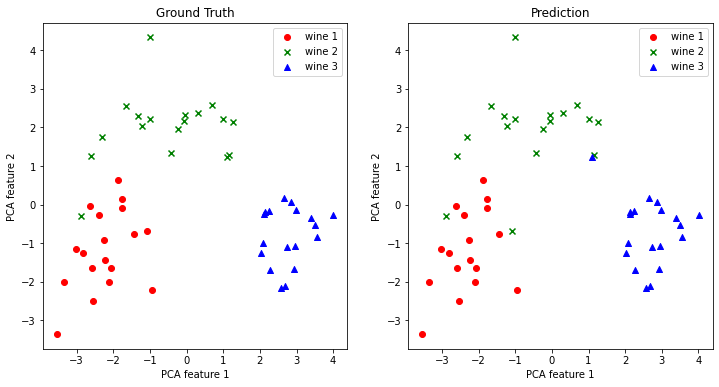

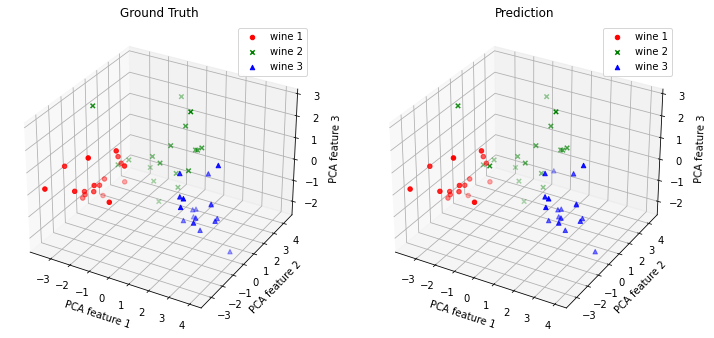

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def add_scatter(ax, projection: str, pos: np.ndarray, y: np.ndarray, title: str) -> None:
    labels = [1, 2, 3]
    names = ['wine 1', 'wine 2', 'wine 3']
    markers = ['o', 'x', '^']
    colors = ['r', 'g', 'b']

    for label, name, marker, color in zip(labels, names, markers, colors):
        if projection == '2d':
            ax.scatter(pos[label==y, 0], pos[label==y, 1], label=name, marker=marker, c=color)
        else:
            ax.scatter(pos[label==y, 0], pos[label==y, 1], pos[label==y, 2], label=name, marker=marker, c=color)
    ax.set_title(title)
    ax.set_xlabel('PCA feature 1')
    ax.set_ylabel('PCA feature 2')
    if projection == '3d':
        ax.set_zlabel('PCA feature 3')
    ax.legend(loc='upper right')

# Draw 2D
X_test_scaled = StandardScaler().fit_transform(X_test)
pos = PCA(n_components=2).fit_transform(X_test_scaled)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
add_scatter(ax, '2d', pos, y_test, 'Ground Truth')
ax = fig.add_subplot(1, 2, 2)
add_scatter(ax, '2d', pos, y_pred, 'Prediction')
plt.show()

# Draw 3D
X_test_scaled = StandardScaler().fit_transform(X_test)
pos = PCA(n_components=3).fit_transform(X_test_scaled)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
add_scatter(ax, '3d', pos, y_test, 'Ground Truth')
ax = fig.add_subplot(1, 2, 2, projection='3d')
add_scatter(ax, '3d', pos, y_pred, 'Prediction')
plt.show()


## Part 4: The effect of prior distribution
prior是用每個label佔所有training data中的比例計算出來的，由於我們每個類別取的testing data數量都為18筆，所以每個類別的training data數量不會改變，因此prior無論在shuffle前後都會是一樣的，從下面的數據可以看出每個類別的佔比其實沒有差很多，wine 1為0.33、wine 2為0.43、wine 3為0.24。為了測試prior是否會影響posterior，我有在寫個新的class `MAP_Estimation_Without_Prior`繼承`MAP_Estimation`並將posterior的計算方式改成只乘likelihood。

為了觀察prior的分布會不會影響兩者的結果，因此我將wine 1與wine 3的training data數設成40，再將wine 2的training data數從10增加到70，以觀察不同的prior分布是否會影響結果。由於training data與testing data的分配也會影響準確率，因此我會重新shuffle資料並隨機分成training data與testing data，再用兩個不同的計算方式去預測，並重複此動作三次取平均的accuracy作為最終結果。

由下圖可以看出，在不同的prior分布下，without prior準確率不是比with prior高就是與with prior相同。會造成這個結果，我認為是因為當prior分布差異較大時，加上prior的分布很有可能誤導model做出錯誤的預測，由於拿掉prior與均勻分布的prior情況一樣，因此可以看到三個wine的數量都是40的平均accuracy相同。

In [5]:
print('priors:', mape.priors)

priors: {1: 0.33064516129032256, 2: 0.4274193548387097, 3: 0.24193548387096775}


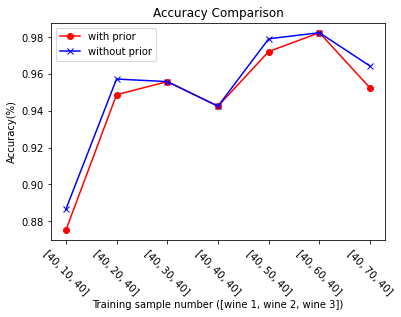

In [6]:
from sklearn.metrics import accuracy_score

class MAP_Estimation_Without_Prior(MAP_Estimation):
    def predict(self, X: np.ndarray) -> np.ndarray:
        y_pred = []
        for data in X:
            posteriors = []
            for label in self.labels:
                posterior = 1.
                parameter = self.parameters[label]
                for i, (mean, sigma) in enumerate(parameter):
                    posterior *= self._likelihood(data[i], mean, sigma)
                posteriors.append(posterior)
            label_idx = np.argmax(posteriors)
            y_pred.append(self.labels[label_idx])
        return np.array(y_pred)

np.random.seed(0)
with_prior_list = []
without_prior_list = []
xtick_list = []
for i in range(7):
    n_trains = [40, (i + 1) * 10, 40]
    with_prior = 0
    without_prior = 0

    n_eval = 3
    for _ in range(n_eval):
        train_array, test_array = split_data('Wine.csv', n_trains=n_trains)
        X_train, y_train = train_array[:, 1:], train_array[:, 0].astype(int)
        X_test, y_test = test_array[:, 1:], test_array[:, 0].astype(int)

        mape = MAP_Estimation()
        mape.fit(X_train, y_train)
        y_pred = mape.predict(X_test)
        with_prior += accuracy_score(y_test, y_pred)

        mape_wo_p = MAP_Estimation_Without_Prior()
        mape_wo_p.fit(X_train, y_train)
        y_pred = mape_wo_p.predict(X_test)
        without_prior += accuracy_score(y_test, y_pred)
    
    xtick_list.append(str(n_trains))
    with_prior_list.append(with_prior / n_eval)
    without_prior_list.append(without_prior / n_eval)

plt.plot(with_prior_list, 'ro-', label='with prior')
plt.plot(without_prior_list, 'bx-', label='without prior')
plt.title('Accuracy Comparison')
plt.xlabel('Training sample number ([wine 1, wine 2, wine 3])')
plt.ylabel('Accuracy(%)')
plt.xticks(list(range(len(xtick_list))), xtick_list, rotation=-45)
plt.legend()
plt.show()